<a href="https://colab.research.google.com/github/ykitaguchi77/Colab_Scripts/blob/master/MNIST_Circle_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Circle_Loss_MNIST**
https://cpp-learning.com/circle-loss/

In [3]:
import os
from typing import Tuple
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
 
import torch
from torch import nn, Tensor
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.transforms import ToTensor

use_cuda = torch.cuda.is_available() and True
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
#DataLoader
def get_loader(is_train: bool, batch_size: int) -> DataLoader:
    trainset = datasets.MNIST(
                                root="./data",
                                train=is_train,
                                transform=ToTensor(),
                                download=True
                              )
    return DataLoader(trainset, batch_size=batch_size, shuffle=is_train)

# data loder
train_loader = get_loader(is_train=True, batch_size=64)



#Visualize Circle Loss
def visualize(features, labels, num_classes):
    # t-SNEで2次元に圧縮
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
    features = tsne.fit_transform(features)
    
    # カラーマップ
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    
    # 描画
    for i in range(num_classes):
        plt.plot(features[labels == i, 0], features[labels == i, 1], '.', c=colors[i])

    # グラフ設定
    plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc='upper right')
    plt.show()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
#Define Circle Loss
def convert_label_to_similarity(normed_feature: Tensor, label: Tensor) -> Tuple[Tensor, Tensor]:
    similarity_matrix = normed_feature @ normed_feature.transpose(1, 0)
    label_matrix = label.unsqueeze(1) == label.unsqueeze(0)

    positive_matrix = label_matrix.triu(diagonal=1)
    negative_matrix = label_matrix.logical_not().triu(diagonal=1)

    similarity_matrix = similarity_matrix.view(-1)
    positive_matrix = positive_matrix.view(-1)
    negative_matrix = negative_matrix.view(-1)
    return similarity_matrix[positive_matrix], similarity_matrix[negative_matrix]


class CircleLoss(nn.Module):
    def __init__(self, m: float, gamma: float) -> None:
        super(CircleLoss, self).__init__()
        self.m = m
        self.gamma = gamma
        self.soft_plus = nn.Softplus()

    def forward(self, sp: Tensor, sn: Tensor) -> Tensor:
        ap = torch.clamp_min(- sp.detach() + 1 + self.m, min=0.)
        an = torch.clamp_min(sn.detach() + self.m, min=0.)

        delta_p = 1 - self.m
        delta_n = self.m

        logit_p = - ap * (sp - delta_p) * self.gamma
        logit_n = an * (sn - delta_n) * self.gamma

        loss = self.soft_plus(torch.logsumexp(logit_n, dim=0) + torch.logsumexp(logit_p, dim=0))

        return loss

In [6]:
#Make CNN Model
class Model(nn.Module):
    def __init__(self) -> None:
        super(Model, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )

    def forward(self, input: Tensor) -> Tensor:
        feature = self.feature_extractor(input).mean(dim=[2, 3])
        return nn.functional.normalize(feature)

In [7]:
#Trainng
def train(criterion, epoch):
    print("Training... Epoch = %d" % epoch)
    for img, label in tqdm(train_loader):
        img, label = img.to(device), label.to(device)
        model.zero_grad()
        pred = model(img)
        loss = criterion(*convert_label_to_similarity(pred, label))
        loss.backward()
        optimizer.step()

In [8]:
# model
model = Model().to(device)

# optimzer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
sheduler = lr_scheduler.StepLR(optimizer, 20, gamma=0.8)

# CircleLoss
criterion = CircleLoss(m=0.25, gamma=80).to(device)

# Training
for epoch in range(20):
    sheduler.step()
    train(criterion, epoch+1)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training... Epoch = 1


100%|██████████| 938/938 [00:14<00:00, 66.71it/s]


Training... Epoch = 2


100%|██████████| 938/938 [00:17<00:00, 53.15it/s]


Training... Epoch = 3


100%|██████████| 938/938 [00:12<00:00, 77.04it/s]


Training... Epoch = 4


100%|██████████| 938/938 [00:12<00:00, 76.67it/s]


Training... Epoch = 5


100%|██████████| 938/938 [00:12<00:00, 73.78it/s]


Training... Epoch = 6


100%|██████████| 938/938 [00:17<00:00, 53.13it/s]


Training... Epoch = 7


100%|██████████| 938/938 [00:19<00:00, 47.41it/s]


Training... Epoch = 8


100%|██████████| 938/938 [00:19<00:00, 48.50it/s]


Training... Epoch = 9


100%|██████████| 938/938 [00:19<00:00, 48.50it/s]


Training... Epoch = 10


100%|██████████| 938/938 [00:12<00:00, 76.50it/s]


Training... Epoch = 11


100%|██████████| 938/938 [00:12<00:00, 77.00it/s]


Training... Epoch = 12


100%|██████████| 938/938 [00:12<00:00, 77.95it/s]


Training... Epoch = 13


100%|██████████| 938/938 [00:12<00:00, 77.62it/s]


Training... Epoch = 14


100%|██████████| 938/938 [00:12<00:00, 74.86it/s]


Training... Epoch = 15


100%|██████████| 938/938 [00:17<00:00, 55.17it/s]


Training... Epoch = 16


100%|██████████| 938/938 [00:13<00:00, 67.14it/s]


Training... Epoch = 17


100%|██████████| 938/938 [00:18<00:00, 49.68it/s]


Training... Epoch = 18


100%|██████████| 938/938 [00:12<00:00, 77.13it/s]


Training... Epoch = 19


100%|██████████| 938/938 [00:12<00:00, 77.59it/s]


Training... Epoch = 20


100%|██████████| 938/938 [00:12<00:00, 76.83it/s]


100%|██████████| 5000/5000 [00:08<00:00, 615.69it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


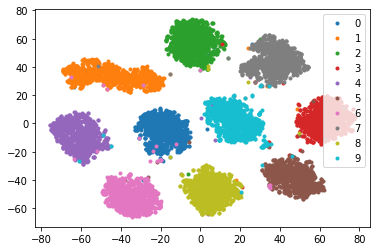

In [9]:
#Visualize results

# data loader
val_loader = get_loader(is_train=False, batch_size=2)

# 保存用
all_features = []
all_labels = []

# 推論
for img, label in tqdm(val_loader):
    img, label = img.to(device), label.to(device)
    pred = model(img)

    all_features.append(pred.data.cpu().numpy())
    all_labels.append(label.data.cpu().numpy())
    
# 可視化
all_features = np.concatenate(all_features, 0)
all_labels = np.concatenate(all_labels, 0)
visualize(all_features, all_labels, 10)